This is an example (popular problem) on a univariate timeseries forecasting. 
I am doing the task using the methods of: ARIMA, SARIMA, Prophet and RNN (LSTM).

```
I'll provide another notebook on multivariate timeseries analysis — where you have further measurements beyond one variable as a function of time.
```



In [ ]:
!pip install pmdarima


     |████████████████████████████████| 1.5 MB 5.4 MB/s 
     |████████████████████████████████| 9.5 MB 14.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:

"""

Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.



For pmdarima:
pip install pmdarima
"""

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# read dataset
df = pd.read_csv('AirPassengers.csv')
df.head(100)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
95,1956-12,306
96,1957-01,315
97,1957-02,301
98,1957-03,356


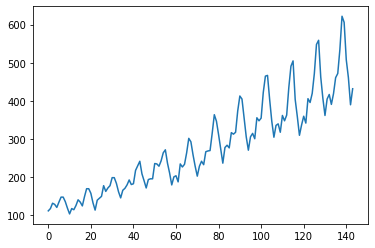

In [ ]:
plt.plot(df['Passengers'])

Make sure your index is a datetime type

In [ ]:
print(df.dtypes)

Month         object
Passengers     int64
dtype: object


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)

Month         datetime64[ns]
Passengers             int64
dtype: object


Clearly this is a univariate time series — we want to make sure the index is the timestep rather than the random Pandas one.

In [ ]:
df.set_index('Month', inplace=True) 

df.head(100)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1956-12-01,306
1957-01-01,315
1957-02-01,301


Inspect through **resampling** — helpful for visualising potentional trend and/or seasonal patterns — day, week, year, and it even can be used for interpolation in case of missing values — check the ```resample``` method of pandas

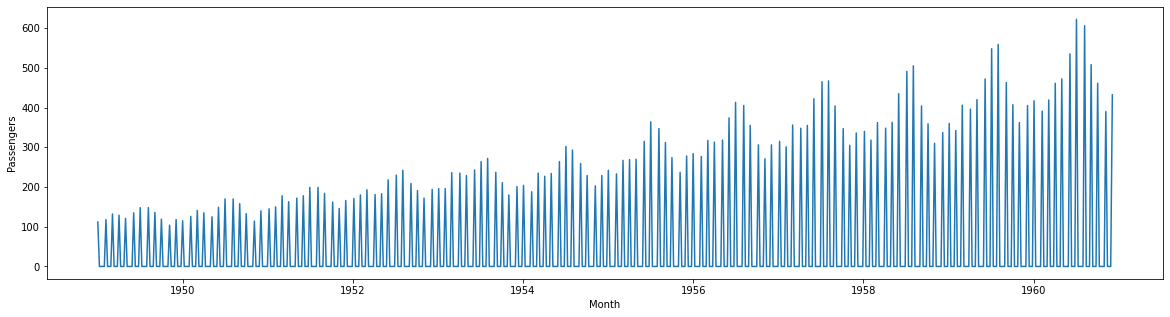

In [ ]:
df_by_week = df.resample('W').sum()
#df_by_month.head()
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(20, 5)
sns.lineplot(x=df_by_week.index, y="Passengers", data=df_by_week, ax=ax1);
#plt.plot(df_by_week['Passengers'])
#df_by_week.head(100)

**Further Checks**

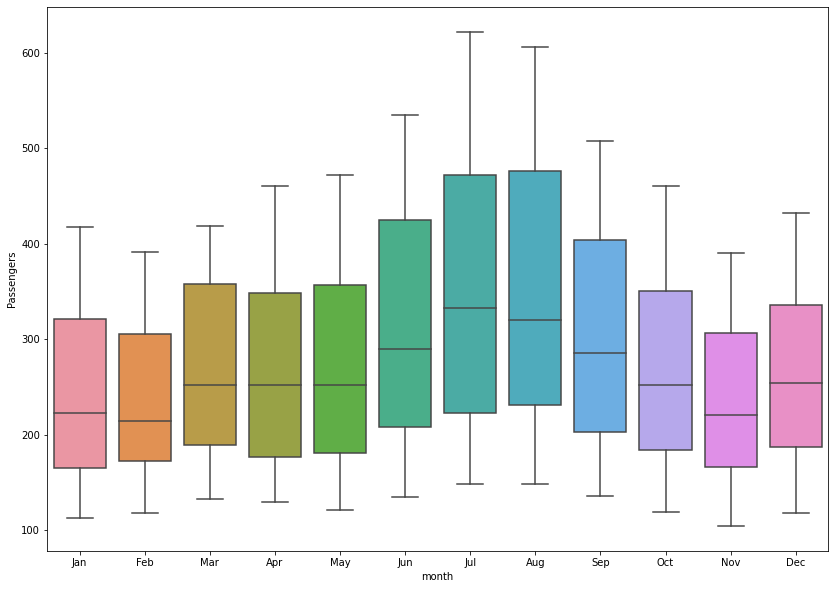

In [ ]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

plt.figure(figsize=(14,10))
#Plot yearly and monthly values as boxplot
sns.boxplot(x='month', y='Passengers', data=df)

#Is the data stationary?
`Dickey-Fuller` test  

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has 

*   Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
*   Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A **p-value** below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary, otherwise a **p-value** above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


> ```From Jason B.'s Book "Time series forecasting with Python" 2020, PP. 140```







In [ ]:

from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df['Passengers'])
print("pvalue = ", pvalue)


pvalue =  0.9918802434376409


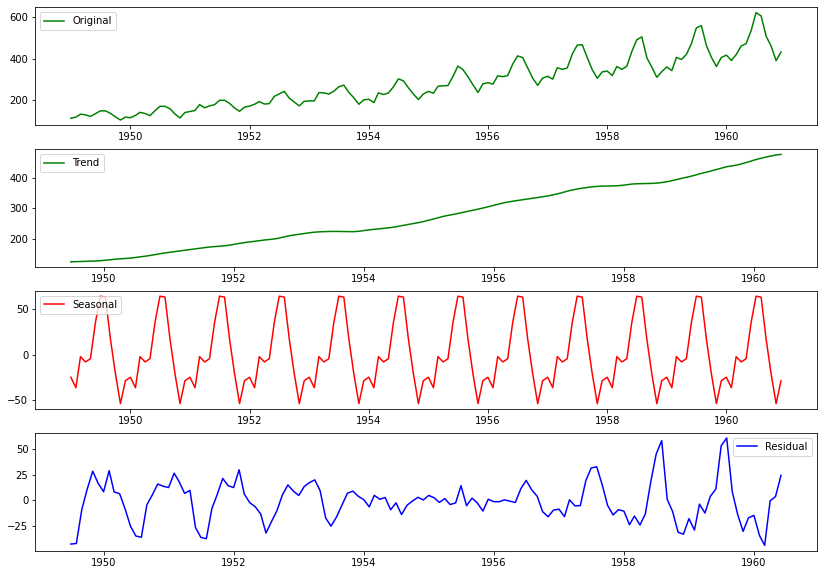

In [ ]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'] , model ='additive')

#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

trend = decomposed.trend
seasonal = decomposed.seasonal 
residual = decomposed.resid

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(df['Passengers'], label='Original', color='green')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='blue')
plt.legend(loc='upper right')
plt.show()



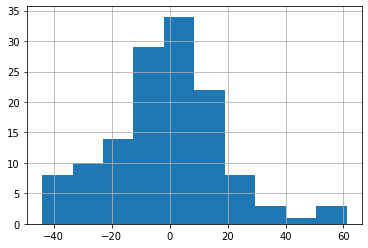

In [ ]:
hist = residual.hist()


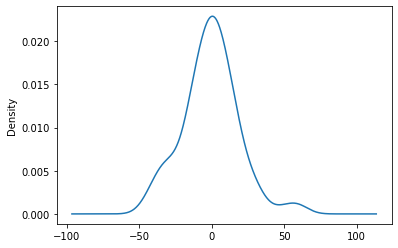

In [ ]:
residual.plot(kind='kde')
plt.show()


 
# Estimating (p, q , d)

**Check Autocorrelation (Correlogram) and the Partial Autocorrelation.**

An autocorrelation of **lag 1** will measure the relationship between this month's value $(y_t)$ and last month's value  $(y_{t-1})$. The values of the autocorrelation function and partial autocorrelation function can help us  estimate $AR (p)$ terms, and $MA (q)$ terms, respectively.



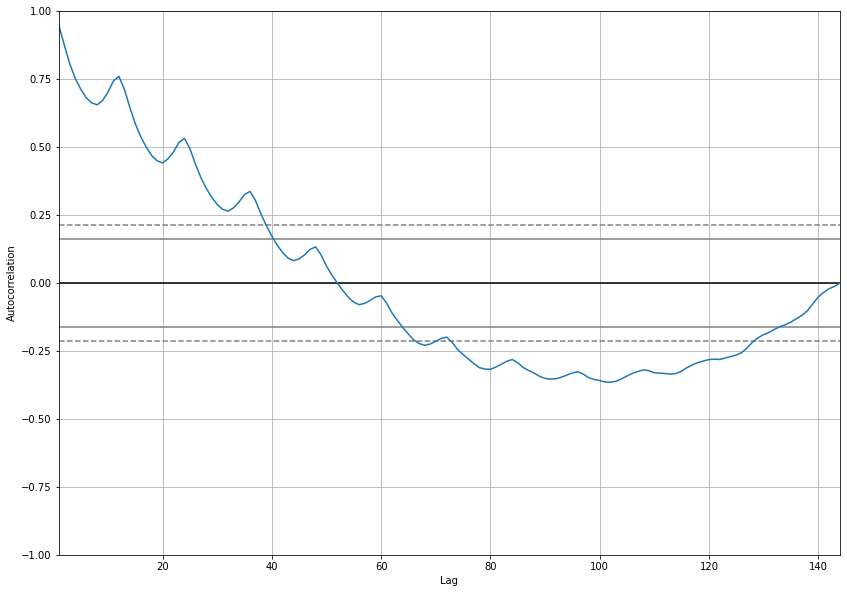

In [ ]:
plt.figure(figsize=(14,10))

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df.Passengers)


In [ ]:
!pip install statsmodels 

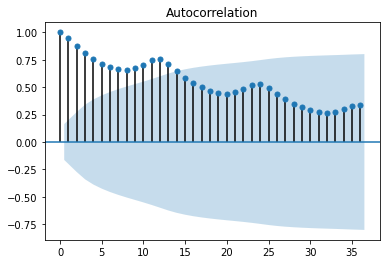

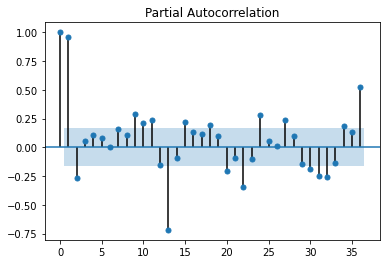

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df.Passengers, lags=36) 
plt.show()

plot_pacf(df.Passengers, lags=36) 
plt.show()



**Estimating AR terms**

To estimate the amount of AR terms, you need to look at the **PACF** plot. First, ignore the value at lag 0. It will always show a perfect correlation, since we are estimating the correlation between today’s value with itself. Note that there is a blue area in the plot, representing the confidence interval. To estimate how much AR terms you should use, start counting how many spikes are above or below the confidence interval before the next ones enter the blue area.

So, looking at the **PACF** plot above, we can estimate to use 1 AR terms (or even 0, will be explained later) for our model, since only lag 1 is out of the confidence interval, and following lags are in the blue area.

---
**Estimating MA terms**

We generally look at the **ACF** plot. The same logic is applied here: how much spikes are above or below the confidence interval before the next spike enters the blue area?

In the example above, we can estimate 1 MA term, since we have only lag 1 out of the confidence interval.

---
**Estimating *I* terms**

How transformation from non-stationary to stationary has been done — if through Differencing, how many Differencing (order or size) was used to make the series stationary. For example, if you used log difference or first difference to transform a time series, the amount of *I* terms will be 1 — this usually can be done automatically, so here one a differencing order of one was needed to remove the trend from the timeseries. 




```
First order differencing   
```
$y_t = y_t - y_{t-1}$

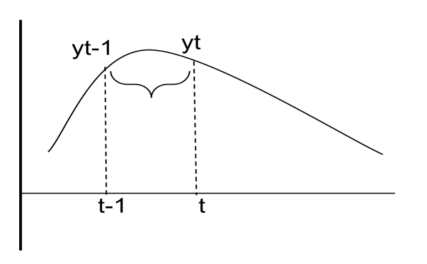

**So you can think of an ARIMA model with $p = 0$ or $1$, $q=1$, and $d=1$**

Let's do the model!

In [ ]:
#AUXILIARY. Just to get the dataframe back in its shape as before as I added other columns; year, month, etc. 
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True) 





---




**Test and Train** 



In [ ]:
train_size = int(len(df) * 0.66)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]
print(len(train), len(test))
test.shape
#train.shape
#train.head()
#print(test)

95 49


(49, 1)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

model = ARIMA(df['Passengers'], order=(1,1,1))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())




                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Tue, 24 Aug 2021   AIC                           1394.683
Time:                        15:42:02   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


**Inspect model  residuals — we may have not considered all patterns in data?**

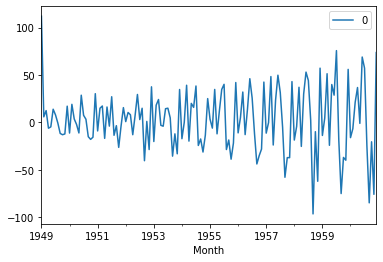

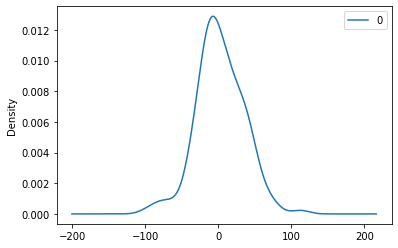

In [ ]:
# line plot of residuals
residuals = DataFrame(model_fit.resid) 

residuals.plot()

plt.show()
# density plot of residuals 
residuals.plot(kind='kde', label='Residuals')
plt.show()
# summary stats of residuals print(residuals.describe())



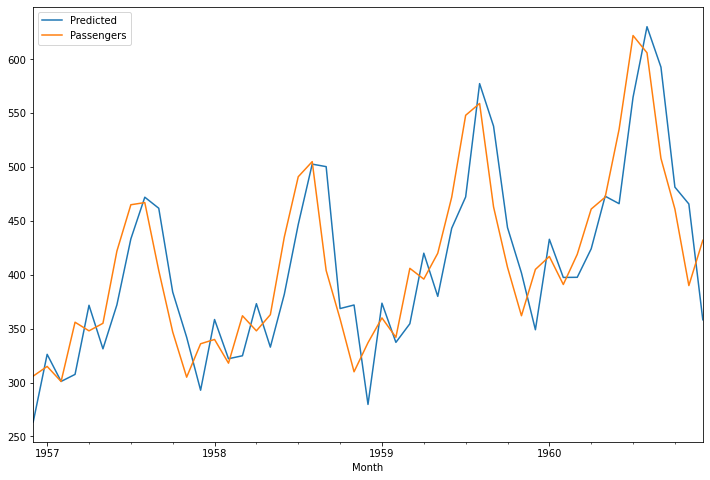

In [ ]:
#Train prediction
start_index = 0
end_index = len(train)-1
train_prediction = model_fit.predict(start_index, end_index) 

#Prediction (test set)
start_index = len(train)
end_index = len(df)-1
prediction = model_fit.predict(start_index, end_index).rename('Predicted ') 
#Rename the column

# plot predictions and actual values
plt.figure(figsize=(12,8))
prediction.plot(legend = True)
test['Passengers'].plot(legend = True)   # true values


Evaluate the model — RMSE but can be MAE, MSE

In [ ]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.20 RMSE
Test Score: 43.93 RMSE


$R^2$?

In [ ]:
from sklearn.metrics import r2_score
score = r2_score(test, prediction)
print("R2 score is: ", score)

R2 score is:  0.6858272419753603


**`Predict next two years, a value for each month of future 24. `**

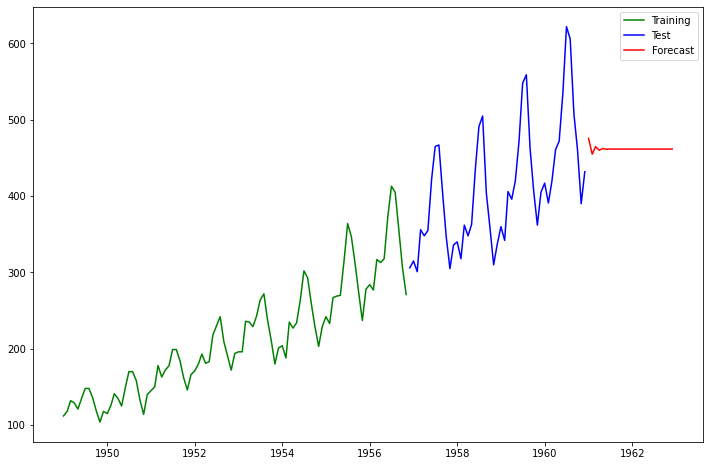

In [ ]:
forecast = model_fit.predict(start = len(df),  
                          end = (len(df)-1) +2 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(train, label='Training', color='green')
plt.plot(test, label='Test', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.legend(loc='Left corner')
plt.show()

# Rolling Forecast and Validation — Walk forward validation - `please check out.`
The ARIMA model can be used to forecast future time steps. We can use the `predict()` function on the ARIMA Results object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indices are relative to the start of the training dataset used to make predictions.
If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction. We also would prefer the forecasted values to be in the original scale, in case we performed any differencing
(d > 0 when configuring the model). This can be specified by setting the typ argument to the `value ’levels’: typ=’levels’`.
Alternately, we can avoid all of these specifications by using the `forecast() `function which performs a one-step forecast using the model. We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.
A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received. We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration. Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.

> ```From Jason B.'s Book "Time series forecasting with Python" 2020, PP. 215```



predicted=415.026125, expected=407.000000
predicted=392.219975, expected=362.000000
predicted=365.550227, expected=405.000000
predicted=458.449443, expected=417.000000
predicted=425.806071, expected=391.000000
predicted=383.785947, expected=419.000000
predicted=417.446171, expected=461.000000
predicted=468.648234, expected=472.000000
predicted=471.498326, expected=535.000000
predicted=541.455152, expected=622.000000
predicted=631.506421, expected=606.000000
predicted=580.686925, expected=508.000000
predicted=460.585028, expected=461.000000
predicted=451.498308, expected=390.000000
predicted=384.126512, expected=432.000000
Test RMSE: 45.563


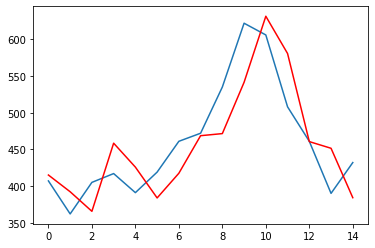

In [ ]:
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.metrics import mean_squared_error 
from math import sqrt

X = df.values
size = int(len(X) * 0.9)
trainR, testR = X[0:size], X[size:len(X)] 
history = [x for x in trainR] 
predictionsR = list()
# walk-forward validation
for t in range(len(testR)):
  model = ARIMA(history, order=(5,1,0)) 
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0] 
  predictionsR.append(yhat)
  obs = testR[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(testR, predictionsR)) 
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes 
plt.plot(testR)
plt.plot(predictionsR, color='red') 
plt.show()

Running the example prints the prediction and expected value each iteration. We can also calculate a final root mean squared error score (RMSE) for the predictions, providing a point of comparison for other ARIMA configurations.

A line plot is created showing the expected values compared to the rolling forecast predictions. We can see the values show some trend and are in the correct scale.



# Including the Seasonality — Seasonal terms
SARIMA $(p, q, d) (P, Q, D)m$

In **SARIMA(P, Q, D)m**: **m** is the seasonal factor. It’s the number of time steps for a single seasonal period.

In the ACF and PACF plots below, we observe second highst spikes happening each 12 months so you would expect **m**  equal to 12.

The **(P, D, Q)** are the analogs of (p, q, d), except for the seasonal components.


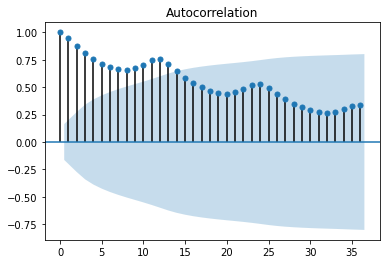

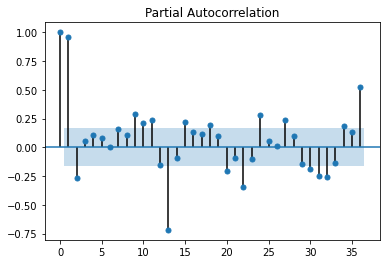

In [ ]:
# reporducing the aucorrelation and partial autcorrelations functions above
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df.Passengers, lags=36) 
plt.show()

plot_pacf(df.Passengers, lags=36) 
plt.show()


# Auto ARIMA to estimate best model ($(p, q, d) (P, Q, D)m$)
It's important to understand it all, and occasionaly to double check if the Auto Arima doesn't make sense. That said, you can either do a Grid Search (manually) for best ARIMA model, or simply call autoarima (which is pretty much similar to a grid search) to give you best model. Example on same problem below: 

In [ ]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)   

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.39 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.47 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=5.70 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.27 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.52 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.71 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [ ]:
print(arima_model.summary() )

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Tue, 24 Aug 2021   AIC                           1019.178
Time:                                     15:42:31   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

In [ ]:
# Build the model on your training set
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
my_model = model.fit() 
#my_model.summary() 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


**`Evaluate the chosen model `**

Train Score: 16.14 RMSE
Test Score: 29.48 RMSE
R2 score is:  0.8584607089167913


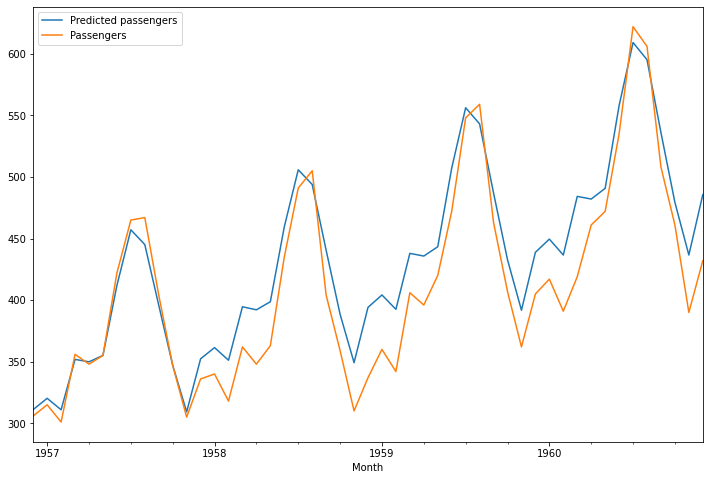

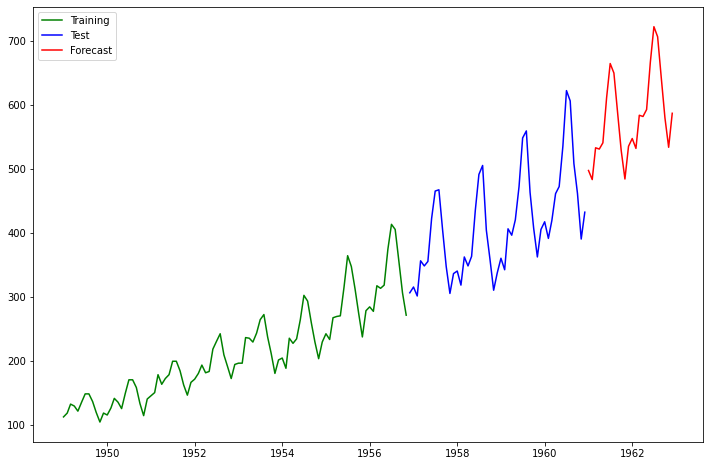

In [ ]:
#Train prediction
start_index = 0
end_index = len(train)-1
train_prediction = my_model.predict(start_index, end_index) 

#Prediction
start_index = len(train)
end_index = len(df)-1
prediction = my_model.predict(start_index, end_index).rename('Predicted passengers') 
#Rename the column

# plot predictions and actual values 
plt.figure(figsize=(12,8))
prediction.plot(legend = True) 
test['Passengers'].plot(legend = True) 


import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

from sklearn.metrics import r2_score
score = r2_score(test, prediction)
print("R2 score is: ", score)


# Forecast for the next 2 years 
forecast = my_model.predict(start = len(df),  
                          end = (len(df)-1) + 2 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(train, label='Training', color='green')
plt.plot(test, label='Test', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.legend(loc='Left corner')
plt.show()

Clearly a much better model — better visually, better on RMSE and also better on $R^2$

# With FB Prophet
---


 

I am doing the same on the above dataset but this time with FB Prophet. 

FB Prophet needs the vectors (columns) to be named 'ds' for the timesteps, and 'y' for the values for the target variable.

Reading again the dataset as I manipulated it earlier. 


Note: Prophet only works on univariate timeseries. Our dataset is Univariate so all should be good. 

In [ ]:
df = pd.read_csv('AirPassengers.csv')
df.head(100)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
95,1956-12,306
96,1957-01,315
97,1957-02,301
98,1957-03,356


Renaming the columns as the method requires — and making sure the index for the table is the 'ds' [the timesteps]


In [ ]:

df['ds'] = pd.to_datetime(df['Month'])
df.set_index('ds') 
#df_prophet = df.drop('Month', axis=1)
df_prophet = df.copy()
#df_prophet = df.drop('Month', axis=1)
df_prophet.rename(columns={'Passengers': 'y'}, inplace=True)
df_prophet

,Month,y,ds
ds,,,
1949-01-01,1949-01,112,1949-01-01
1949-02-01,1949-02,118,1949-02-01
1949-03-01,1949-03,132,1949-03-01
1949-04-01,1949-04,129,1949-04-01
1949-05-01,1949-05,121,1949-05-01
...,...,...,...
1960-08-01,1960-08,606,1960-08-01
1960-09-01,1960-09,508,1960-09-01
1960-10-01,1960-10,461,1960-10-01


Fitting the model — just a first check that all in place. 

In [ ]:
from fbprophet import Prophet
from pandas import to_datetime



FBmodel = Prophet()
#df['ds']= to_datetime(df.index)
#df['ds']= to_datetime(df['ds'])

FBmodel.fit(df_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Split the dataset into training and testing — just as with Arima.  Note that here I do not need to define 'lags' — you just plug the timeseries into Prophet and it does the magic (well, sometimes...the general recommendation is that you'd need at least 50 readings, ie, measurements corresponding to at least 50 timestemps, but again, this is't backed theoritically).


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


95 49


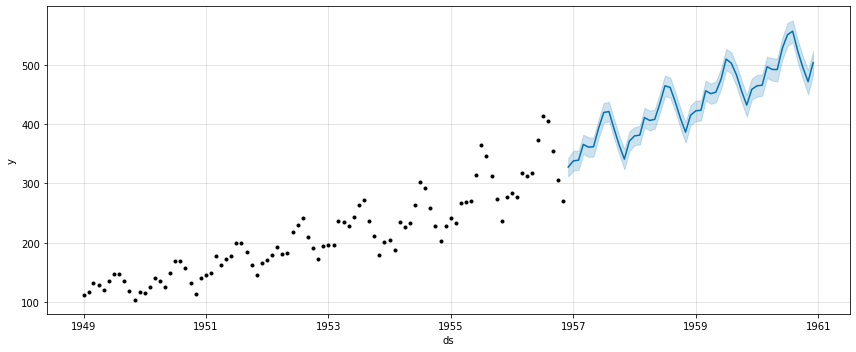

In [ ]:
train_size = int(len(df_prophet) * 0.66)
test_size = len(df_prophet) - train_size
train, test = df_prophet[0:train_size], df_prophet[train_size:len(df_prophet)]
print(len(train), len(test))
#print(test.dtypes)


FBmodel = Prophet()
FBmodel.fit(train)

train_prediction = FBmodel.predict(train) 
#train_prediction.head()
test_prediction = FBmodel.predict(test)
#test_prediction.head()



f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(12)
fig = FBmodel.plot(test_prediction,
                 ax=ax)
plt.show()



The dataset is a montly timeseries so daily and weekly seasonality isn't provided (or available). Usually you can include these if your data is of higher time resolution (ie, hourly, daily and/or weekly measurements). 

Also, one could include a holidays Calendar usually — so the model considers these in its calculations (UK government provides a bank holidays API so that you can get a calendar that can turn very useful in Prohpet's timeseries forecasting). In fact, Prophet is particularly good at accounting for holidays, as well as dealing with series with missing data (values). 

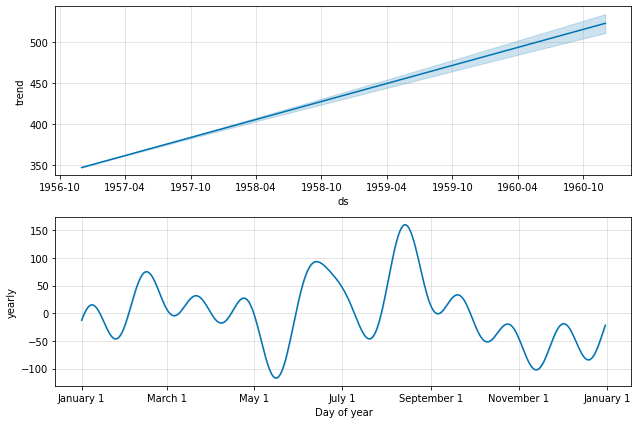

In [ ]:
fig = FBmodel.plot_components(test_prediction)

Just checking I've got the test data shape in order.

In [ ]:
test['y'].head()

ds
1956-12-01    306
1957-01-01    315
1957-02-01    301
1957-03-01    356
1957-04-01    348
Name: y, dtype: int64

And whether the index is being 'ds' (or the timestep)

In [ ]:
test.index

DatetimeIndex(['1956-12-01', '1957-01-01', '1957-02-01', '1957-03-01',
               '1957-04-01', '1957-05-01', '1957-06-01', '1957-07-01',
               '1957-08-01', '1957-09-01', '1957-10-01', '1957-11-01',
               '1957-12-01', '1958-01-01', '1958-02-01', '1958-03-01',
               '1958-04-01', '1958-05-01', '1958-06-01', '1958-07-01',
               '1958-08-01', '1958-09-01', '1958-10-01', '1958-11-01',
               '1958-12-01', '1959-01-01', '1959-02-01', '1959-03-01',
               '1959-04-01', '1959-05-01', '1959-06-01', '1959-07-01',
               '1959-08-01', '1959-09-01', '1959-10-01', '1959-11-01',
               '1959-12-01', '1960-01-01', '1960-02-01', '1960-03-01',
               '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01',
               '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01',
               '1960-12-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

Plotting test prediction against true values - not bad (the pattern at least has been captured)

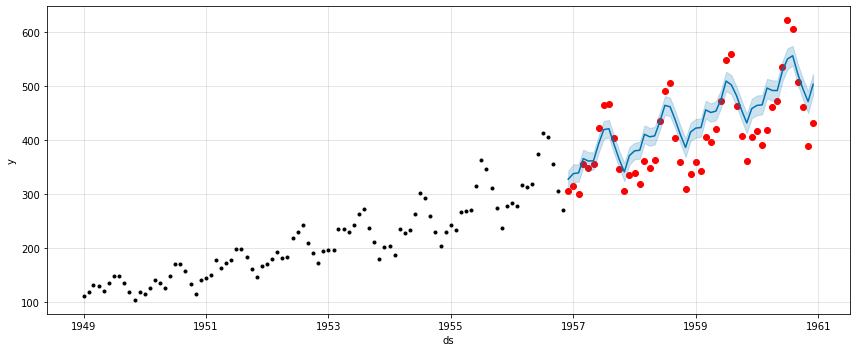

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(12)
ax.scatter(test.index, test['y'], color='r')
fig = FBmodel.plot(test_prediction, ax=ax)

Check evaluation metrics. As before with ARIMA. 

SARIMA does much better it seems — but that's quite expected. Where short term seasonality doesnt exist, Prophet cannot quite compete with a good regressor like ARIMA. Obvioulsy here there isn't daily, hourly, weekend, etc data which is available and thus the relatively poor results.

In [ ]:
trainScore = math.sqrt(mean_squared_error(train['y'], train_prediction['yhat']))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test['y'], test_prediction['yhat']))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 12.59 RMSE
Test Score: 47.54 RMSE


Same with the R squared metric. 

In [ ]:
from sklearn.metrics import r2_score
score = r2_score(test['y'], test_prediction['yhat'])
print("R2 score is: ", score)

R2 score is:  0.6319561350494787


To make predictions — you just need to define the period in the future. 

If our timestep is a month, that means frequency is counted by month unit, and as such if I want to predict 2 years ahead, I'd need to specify 24 for that - see below. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


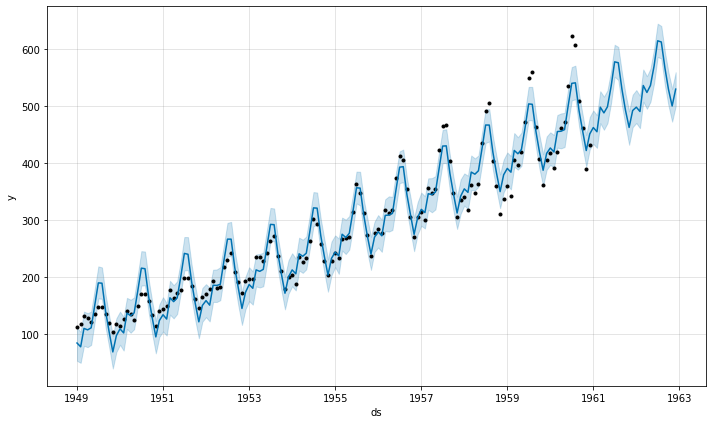

In [ ]:
# Forecast for the next 2 years 
FBmodel_final = Prophet()
FBmodel_final.fit(df_prophet)

future = FBmodel_final.make_future_dataframe(periods=24, freq='1M')
forecast = FBmodel_final.predict(future)
FBmodel_final.plot(forecast)
plt.show() 




# With Deep Recurrent Neural Networks — LSTMs

In [ ]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True) 
df


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Splitting data into train and test as before

In [ ]:
train_size = int(len(df) * 0.66)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]
print(len(train), len(test))
#test.shape
#train.shape




95 49


For deep neural networks we usually need to rescale the data. This is because an algorithm which is called 'backpropagation' is applied to minimise the loss function (every batch of training the network, forward, the algorithm goes back to all previous layers to update what we call the weights at each neuron; weights are the equivilant of coefficients as you know them in a linear regression function). Now given that this process is highly repetitive and especially when the network is big (ie, many network layers), the backpropagation process would cause overflow errors — and therefore we better rescale data to avoid that. 

`Note that when we do prediction after building the model, we will have to rescale (inverse the scaling process) - you will see later in the code. `

In [ ]:
from sklearn.preprocessing import RobustScaler


transformer = RobustScaler()

transformer = transformer.fit(train[['Passengers']])

train['Passengers'] = transformer.transform(train[['Passengers']])

test['Passengers'] = transformer.transform(test[['Passengers']])

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

We simply create the training and test sets with a sepcified lag — I learnt from the ARIMA analysis (autocorrelation and partial autocorrelation) that you would need a month or two back to predict this month's passengers. So I decided (guided trial and error here) to have a lag of 2 (I call it timestep, I also tried with lag = 1). 

You simply will generate mutiple series of pair values, two timeseries values for training (as the lag is 2), whereby the method should be able to predict the subsequent from the first two - which is provided in y_train.

In [ ]:
TIME_STEPS = 2
X_train, y_train = create_dataset(train, train.Passengers, time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test, test.Passengers, time_steps=TIME_STEPS)
y_test.shape


(47,)

So if you print X_train, you will see its shape being (93, 2, 1), these are:
 

*  93: pairs of values for training  
*  2: the "pair" part of the above — each pair is of two values 
*  1: each pair of values correspond to a future value — ie, for each record of 2 values from the 93 records, 1 value should be predicted in training. 





In [ ]:
X_train.shape

(93, 2, 1)

In [ ]:
# printing the training set after rescaling - cannot visualise well so I show you how all looks in a step.
print (*X_test)

[[0.97272727]
 [1.05454545]] [[1.05454545]
 [0.92727273]] [[0.92727273]
 [1.42727273]] [[1.42727273]
 [1.35454545]] [[1.35454545]
 [1.41818182]] [[1.41818182]
 [2.02727273]] [[2.02727273]
 [2.41818182]] [[2.41818182]
 [2.43636364]] [[2.43636364]
 [1.86363636]] [[1.86363636]
 [1.34545455]] [[1.34545455]
 [0.96363636]] [[0.96363636]
 [1.24545455]] [[1.24545455]
 [1.28181818]] [[1.28181818]
 [1.08181818]] [[1.08181818]
 [1.48181818]] [[1.48181818]
 [1.35454545]] [[1.35454545]
 [1.49090909]] [[1.49090909]
 [2.14545455]] [[2.14545455]
 [2.65454545]] [[2.65454545]
 [2.78181818]] [[2.78181818]
 [1.86363636]] [[1.86363636]
 [1.45454545]] [[1.45454545]
 [1.00909091]] [[1.00909091]
 [1.25454545]] [[1.25454545]
 [1.46363636]] [[1.46363636]
 [1.3       ]] [[1.3       ]
 [1.88181818]] [[1.88181818]
 [1.79090909]] [[1.79090909]
 [2.00909091]] [[2.00909091]
 [2.48181818]] [[2.48181818]
 [3.17272727]] [[3.17272727]
 [3.27272727]] [[3.27272727]
 [2.4       ]] [[2.4       ]
 [1.89090909]] [[1.89090909]


Here I am printing what I have just explained above — the 99 pairs to predict a value in y_test (which is a lagged value from the timeseries itself) 

In [ ]:
c = 0
for i in X_test:
    for j in i:
        for val in j:
            print(val,  end = ' ')

    print(end =" ") # this is just to add the next printing in the same line
    print (" -- to predict:", y_test[c])
    c = c+1

0.9727272727272728 1.0545454545454545   -- to predict: 0.9272727272727272
1.0545454545454545 0.9272727272727272   -- to predict: 1.4272727272727272
0.9272727272727272 1.4272727272727272   -- to predict: 1.3545454545454545
1.4272727272727272 1.3545454545454545   -- to predict: 1.4181818181818182
1.3545454545454545 1.4181818181818182   -- to predict: 2.0272727272727273
1.4181818181818182 2.0272727272727273   -- to predict: 2.418181818181818
2.0272727272727273 2.418181818181818   -- to predict: 2.4363636363636365
2.418181818181818 2.4363636363636365   -- to predict: 1.8636363636363635
2.4363636363636365 1.8636363636363635   -- to predict: 1.3454545454545455
1.8636363636363635 1.3454545454545455   -- to predict: 0.9636363636363636
1.3454545454545455 0.9636363636363636   -- to predict: 1.2454545454545454
0.9636363636363636 1.2454545454545454   -- to predict: 1.2818181818181817
1.2454545454545454 1.2818181818181817   -- to predict: 1.0818181818181818
1.2818181818181817 1.0818181818181818   -

This part of the model needs a recording — "God" help me — will do!

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=20, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
5/5 [==============================] - 4s 263ms/step - loss: 0.2816 - val_loss: 1.6375
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 0.2587 - val_loss: 1.5111
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 0.2396 - val_loss: 1.3852
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 0.2211 - val_loss: 1.2632
Epoch 5/30
5/5 [==============================] - 0s 7ms/step - loss: 0.2036 - val_loss: 1.1455
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 0.1901 - val_loss: 1.0324
Epoch 7/30
5/5 [==============================] - 0s 9ms/step - loss: 0.1746 - val_loss: 0.9238
Epoch 8/30
5/5 [==============================] - 0s 9ms/step - loss: 0.1596 - val_loss: 0.8198
Epoch 9/30
5/5 [==============================] - 0s 8ms/step - loss: 0.1426 - val_loss: 0.7211
Epoch 10/30
5/5 [==============================] - 0s 8ms/step - loss: 0.1301 - val_loss: 0.6282
Epoch 11/30
5/5 [====================

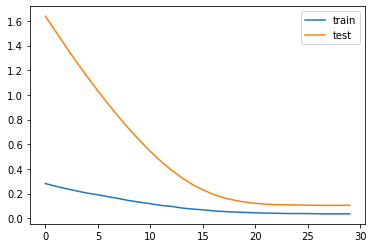

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

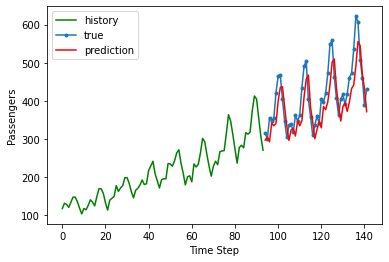

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Passengers')
plt.xlabel('Time Step')
plt.legend()
plt.show();

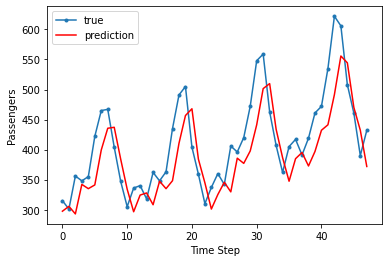

-----------------------------------------------------------
-----------------------------------------------------------
RMSE value on validation set: 51.86693215135189


In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Passengers')
plt.xlabel('Time Step')
plt.legend()
plt.show();
rmse=np.sqrt(np.mean(np.power((np.array(y_test_inv.flatten() - y_pred_inv.flatten())),2)))

print('-----------------------------------------------------------')
print('-----------------------------------------------------------')
print('RMSE value on validation set:',rmse)


In [ ]:
import math
from sklearn.metrics import mean_squared_error
testScore = math.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 51.87 RMSE


In [ ]:
from sklearn.metrics import r2_score
score = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())
print("R2 score is: ", score)

R2 score is:  0.554135557925709


Most deep neural networks are powerful if there's enough representative data — clearly this dataset is small (low temporal resolution, and limited number of observations). LSTMs, a type of recurrent neural networks, whilst "catching" the pattern in the data, yet its overall performance is clearly well below the above two (SARIMA and Prophet). We also need to refer to the complexity of the variability — LSTMs need more data, higher resolition, and it generally performs as good as (or even better) than SARIMA where the variability is more complex (embedded seasonality, less systematic seasonality, etc).